<div style="text-align:center;">
    <h1><b>Scattertext applied to Hyperpartisan News Detection</b></h1>
    <h3><b>Authors:</b> Julen Rodriguez and Mikel Salvoch</h3>
</div>

# 1. Necessary Imports

In [82]:
#numpy under 2.x could be required

In [43]:
import matplotlib.pyplot as plt
import wordcloud
from collections import Counter
import re
import nltk
import numpy as np
import pandas as pd
import scattertext as st
import spacy
import empath
import umap
import pytextrank
from pprint import pprint
from gensim import models

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Data
Assemble the data to analyze into a Pandas data frame. It should have at least two columns, the text you'd like to analyze, and the category to study.

## 2.1. Load the data

In [2]:
# load hyperpartisan\articles-training-byarticle-20181122.tsv
convention_df = pd.read_csv('articles-training-byarticle-20181122.tsv', sep='\t')
# non header, first column: 1 for hyperpartisan, 0 for non-hyperpartisan
convention_df.columns = ['hyperpartisan', 'article']
convention_df['hyperpartisan'] = convention_df['hyperpartisan'].astype(bool)
# we label as hyperpartisan and non_hyperpartisan to avoid problems with True and False reserved words
convention_df['hyperpartisan_types'] = convention_df['hyperpartisan'].map({True: 'Hyperpartisan', False: 'Non-Hyperpartisan'})

In [3]:
nlp = spacy.load("en_core_web_lg")
convention_df = convention_df.assign(parse=lambda df: df.article.apply(nlp))

In [4]:
convention_df.head()

,hyperpartisan,article,hyperpartisan_types,parse
0,True,Trump Just Woke Up & Viciously Attacked Puerto...,Hyperpartisan,"(Trump, Just, Woke, Up, &, Viciously, Attacked..."
1,True,"Liberals wailing about gun control, but what a...",Hyperpartisan,"(Liberals, wailing, about, gun, control, ,, bu..."
2,True,Laremy Tunsil joins NFL players in kneeling du...,Hyperpartisan,"(Laremy, Tunsil, joins, NFL, players, in, knee..."
3,False,It's 1968 All Over Again Almost a half-centur...,Non-Hyperpartisan,"(It, 's, 1968, All, Over, Again, , Almost, a,..."
4,True,Gold Price in December 2017 - Myriads of Signa...,Hyperpartisan,"(Gold, Price, in, December, 2017, -, Myriads, ..."


## 2.2 Load data into Scattertext corpus
Turn the data frame into a Scattertext Corpus to begin analyzing it

In [11]:
# Turn it into a Scattertext Corpus 
corpus_vanila = st.CorpusFromParsedDocuments(convention_df, 
                                    category_col='hyperpartisan_types',
                                    parsed_col='parse').build()

Here are the terms that differentiate the corpus from a general English corpus.

In [13]:
print(list(corpus_vanila.get_scaled_f_scores_vs_background().index[:10]))

['trump', 'twitter', 'obama', 'comey', 'tweeted', 'bannon', 'facebook', 'barack', 'hillary', 'kaepernick']


Here are the terms that are most associated with Hyperpartisan news:

In [12]:
term_freq_df = corpus_vanila.get_term_freq_df()
term_freq_df['Hyperpartisan Score'] = corpus_vanila.get_scaled_f_scores('Hyperpartisan')
pprint(list(term_freq_df.sort_values(by='Hyperpartisan Score', ascending=False).index[:10]))

['the left',
 'class',
 'israel',
 'ruling',
 'china',
 'conservative',
 'ruling class',
 'the ruling',
 'he ’s',
 'the media']


And here are the terms that are most associated with non-Hyperpartisan news:

In [14]:
term_freq_df['Non-Hyperpartisan Score'] = corpus_vanila.get_scaled_f_scores('Non-Hyperpartisan')
pprint(list(term_freq_df.sort_values(by='Non-Hyperpartisan Score', ascending=False).index[:10]))

['send free',
 '|',
 '⚪',
 'california ca',
 'hurricane',
 '⠀',
 'august',
 'los angeles',
 'angeles',
 'los']


# 3. Visualizing the data

## 3.1. WordCloud

In [ ]:
# nltk.download('stopwords')

def clean_and_tokenize(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return tokens

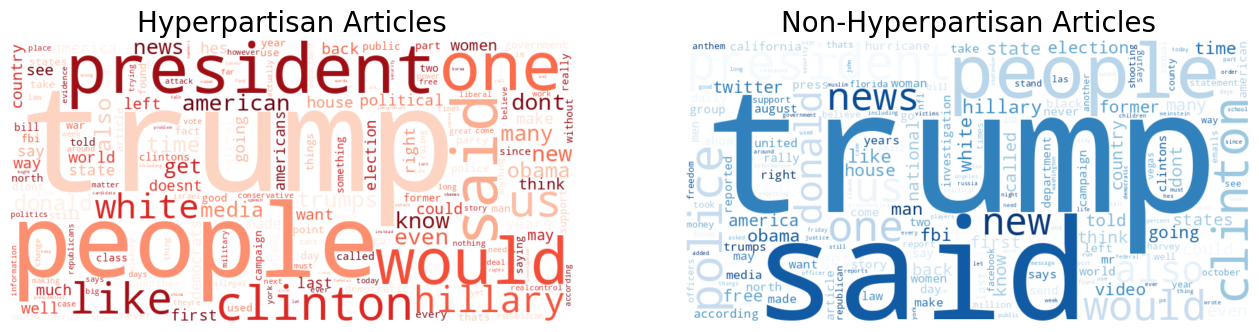

In [45]:
convention_df_wordcloud = convention_df.dropna(subset=['article'])

# Separate the dataframe by class
hyper_df = convention_df_wordcloud[convention_df_wordcloud['hyperpartisan'] == True]
nonhyper_df = convention_df_wordcloud[convention_df_wordcloud['hyperpartisan'] == False]

# Process articles for each class
hyper_text = ' '.join(hyper_df['article'].tolist())
nonhyper_text = ' '.join(nonhyper_df['article'].tolist())

hyper_tokens = clean_and_tokenize(hyper_text)
nonhyper_tokens = clean_and_tokenize(nonhyper_text)

hyper_freq = Counter(hyper_tokens)
nonhyper_freq = Counter(nonhyper_tokens)

# Generate word clouds with distinct color maps
hyper_wc = wordcloud.WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(hyper_freq)
nonhyper_wc = wordcloud.WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(nonhyper_freq)

# Plot the word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(hyper_wc, interpolation='bilinear')
plt.title("Hyperpartisan Articles", fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nonhyper_wc, interpolation='bilinear')
plt.title("Non-Hyperpartisan Articles", fontsize=20)
plt.axis('off')

plt.show()

## 3.2. Scattertext

### 3.1. Visualizing term associations

In [36]:
html = st.produce_scattertext_explorer(
    corpus_vanila,
    category='Hyperpartisan',
    category_name='Hyperpartisan',
    not_category_name='Non-Hyperpartisan',
    width_in_pixels=1000,
    metadata=convention_df['hyperpartisan'],
    use_full_doc=True
)
with open("Convention-Visualization.html", 'wb') as file:
    file.write(html.encode('utf-8'))

### 3.2. Visualizing Phrase associations

In [16]:
nlp_textrank = spacy.load("en_core_web_lg")
nlp_textrank.add_pipe("textrank")

convention_df_textrank = convention_df.assign(parse=lambda df: df.article.apply(nlp_textrank))

corpus_textrank = st.CorpusFromParsedDocuments(
    convention_df_textrank,
    category_col='hyperpartisan_types',
    parsed_col='parse',
    feats_from_spacy_doc=st.PyTextRankPhrases()
).build(
).compact(
    st.AssociationCompactor(2000, use_non_text_features=True)
)

Note that the terms present in the corpus are named entities, and, as opposed to frequency counts, their scores are the eigencentrality scores assigned to them by the TextRank algorithm. Running ```corpus.get_metadata_freq_df('')``` will return, for each category, the sums of terms' TextRank scores. The dense ranks of these scores will be used to construct the scatter plot.

In [17]:
term_category_scores = corpus_textrank.get_metadata_freq_df('')
print(term_category_scores)

                                  Hyperpartisan  Non-Hyperpartisan
term                                                              
Donald Trump                          24.312710          26.926108
Puerto Rican people                    0.095588           0.000000
Trump                                140.860341         105.201622
federal emergency disaster funds       0.088944           0.000000
Puerto Rico                            3.569721           0.452057
...                                         ...                ...
that word                              0.013338           0.000000
the stomach                            0.013147           0.000000
another interview                      0.013019           0.000000
his depravity                          0.012844           0.000000
And possibly tranquilizers             0.005098           0.000000

[48867 rows x 2 columns]


Before we construct the plot, let's some helper variables Since the aggregate TextRank scores aren't particularly interpretable, we'll display the per-category rank of each score in the metadata_description field. These will be displayed after a term is clicked.

In [20]:
term_ranks = pd.DataFrame(
    np.argsort(np.argsort(-term_category_scores, axis=0), axis=0) + 1,
    columns=term_category_scores.columns,
    index=term_category_scores.index)

metadata_descriptions = {
    term: '<br/>' + '<br/>'.join(
        '<b>%s</b> TextRank score rank: %s/%s' % (cat, term_ranks.loc[term, cat], corpus_textrank.get_num_metadata())
        for cat in corpus_textrank.get_categories())
    for term in corpus_textrank.get_metadata()
}

In [21]:
category_specific_prominence = term_category_scores.apply(
    lambda r: r['Hyperpartisan'] if r['Hyperpartisan'] > r['Non-Hyperpartisan'] else -r['Non-Hyperpartisan'],
    axis=1
)

Now we proceed to construct the plot defining an html file to save it.

In [35]:
html = st.produce_scattertext_explorer(
    corpus_textrank,
    category='Hyperpartisan',
    not_category_name='Non-Hyperpartisan',
    minimum_term_frequency=0,
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=st.dense_rank,
    metadata=corpus_textrank.get_df()['hyperpartisan'],
    scores=category_specific_prominence,
    sort_by_dist=False,
    use_non_text_features=True,
    topic_model_term_lists={term: [term] for term in corpus_textrank.get_metadata()},
    topic_model_preview_size=0,
    metadata_descriptions=metadata_descriptions,
    use_full_doc=True
)

with open("Convention-Visualization-TextRank.html", 'wb') as file:
    file.write(html.encode('utf-8'))

### 3.3. Visualizing Empath topics and categories

In order to visualize Empath (Fast et al., 2016) topics and categories instead of terms, we'll need to create a Corpus of extracted topics and categories rather than unigrams and bigrams

In [24]:
convention_df.head()

,hyperpartisan,article,hyperpartisan_types,parse
0,True,Trump Just Woke Up & Viciously Attacked Puerto...,Hyperpartisan,"(Trump, Just, Woke, Up, &, Viciously, Attacked..."
1,True,"Liberals wailing about gun control, but what a...",Hyperpartisan,"(Liberals, wailing, about, gun, control, ,, bu..."
2,True,Laremy Tunsil joins NFL players in kneeling du...,Hyperpartisan,"(Laremy, Tunsil, joins, NFL, players, in, knee..."
3,False,It's 1968 All Over Again Almost a half-centur...,Non-Hyperpartisan,"(It, 's, 1968, All, Over, Again, , Almost, a,..."
4,True,Gold Price in December 2017 - Myriads of Signa...,Hyperpartisan,"(Gold, Price, in, December, 2017, -, Myriads, ..."


In [ ]:
corpus_empath = st.CorpusFromParsedDocuments(convention_df,
                                            category_col='hyperpartisan_types',
                                            parsed_col='parse',
                                            feats_from_spacy_doc=st.FeatsFromOnlyEmpath()
                                            ).build()

In [34]:
html = st.produce_scattertext_explorer(corpus_empath,
                                        category='Hyperpartisan',
                                        category_name='Hyperpartisan',
                                        not_category_name='Non-Hyperpartisan',
                                        width_in_pixels=1000,
                                        metadata=convention_df['hyperpartisan'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=st.FeatsFromOnlyEmpath().get_top_model_term_lists())

with open("Convention-Visualization-Empath.html", 'wb') as file:
    file.write(html.encode('utf-8'))

### 3.4. Ordering Terms by Corpus Characteristicness

We are identifying terms that are frequent within the studied documents but less common in general language. The characteristic score compares these terms against a general English frequency list.

In [27]:
convention_df.head()

,hyperpartisan,article,hyperpartisan_types,parse
0,True,Trump Just Woke Up & Viciously Attacked Puerto...,Hyperpartisan,"(Trump, Just, Woke, Up, &, Viciously, Attacked..."
1,True,"Liberals wailing about gun control, but what a...",Hyperpartisan,"(Liberals, wailing, about, gun, control, ,, bu..."
2,True,Laremy Tunsil joins NFL players in kneeling du...,Hyperpartisan,"(Laremy, Tunsil, joins, NFL, players, in, knee..."
3,False,It's 1968 All Over Again Almost a half-centur...,Non-Hyperpartisan,"(It, 's, 1968, All, Over, Again, , Almost, a,..."
4,True,Gold Price in December 2017 - Myriads of Signa...,Hyperpartisan,"(Gold, Price, in, December, 2017, -, Myriads, ..."


In [28]:
corpus_characteristic = (st.CorpusFromPandas(convention_df,
                            category_col='hyperpartisan_types',
                            text_col='article',
                            nlp=st.whitespace_nlp_with_sentences)
        .build()
        .get_unigram_corpus()
        .compact(st.ClassPercentageCompactor(term_count=2,
                                            term_ranker=st.OncePerDocFrequencyRanker)))

In [33]:
html = st.produce_characteristic_explorer(corpus_characteristic,
                                            category='Hyperpartisan',
                                            category_name='Hyperpartisan',
                                            not_category_name='Non-Hyperpartisan',
                                            metadata=convention_df['hyperpartisan'],
                                            use_full_doc=True,
                                            width_in_pixels=1000)

with open("Convention-Visualization-Characteristics.html", 'wb') as file:
    file.write(html.encode('utf-8'))

### 3.4. Embedding the data and plotting in the same representation space

For this plot, we are going to embedd all the data and represent them in a 2D space with UMAP.

In [30]:
corpus_umap = (
    st.CorpusFromParsedDocuments(
        convention_df,
        category_col='hyperpartisan_types',
        parsed_col='parse'
    )
    .build().get_stoplisted_unigram_corpus()
)

model = models.word2vec.Word2Vec(vector_size=300,
                        alpha=0.025,
                        window=5,
                        min_count=5,
                        max_vocab_size=None,
                        sample=0,
                        seed=1,
                        workers=1,
                        min_alpha=0.0001,
                        sg=1,
                        hs=1,
                        negative=0,
                        cbow_mean=0,
                        null_word=0,
                        trim_rule=None,
                        sorted_vocab=1)

In [ ]:
html = st.produce_projection_explorer(corpus_umap,
                                    word2vec_model=model,
                                    projection_model=umap.UMAP(min_dist=0.5, metric='cosine'),
                                    category='Hyperpartisan',
                                    category_name='Hyperpartisan',
                                    not_category_name='Non-Hyperpartisan',
                                    use_full_doc=True,
                                    width_in_pixels=1000)   

with open("Convention-Visualization-UMAP.html", 'wb') as file:
    file.write(html.encode('utf-8'))